In [1]:
import os
import sys
import json
import pickle
import gzip
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
from importlib import reload
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none' }
plt.rcParams.update(new_rc_params)
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy.stats import ttest_ind, mannwhitneyu
sys.path.append("../scripts")
from utils import set_spines, get_figure_size, get_fontsize_rc_params, count_items
font_params = get_fontsize_rc_params(7.5)
plt.rcParams.update(font_params)

In [2]:
def to_rank(x):
    raw_idx = [t[1] for t in sorted(zip(x, np.arange(len(x))), key=lambda ar:ar[0], reverse=False)]
    new_score = [t[1] for t in sorted(zip(raw_idx, np.arange(1, 1 + len(raw_idx))/len(raw_idx)), key=lambda ar:ar[0])]
    return np.asarray(new_score)

def normalize(x):
    xmin, xmax = x.min(), x.max()
    return (x - xmin) / (xmax - xmin)

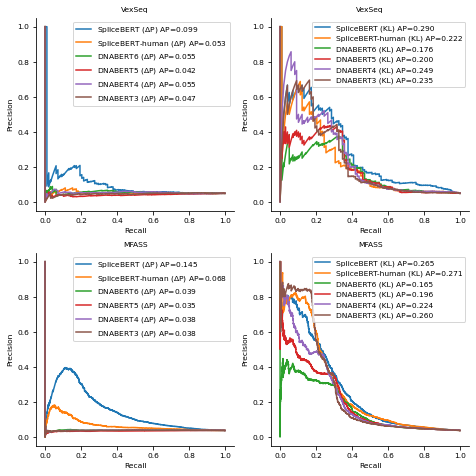

In [3]:
vexseq_results = dict()
mfass_results = dict()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=get_figure_size(width=0.8))
for row, name in enumerate(["VexSeq","MFASS"]):
    if name == "MFASS":
        results = mfass_results
    else:
        results = vexseq_results
    for col, method in enumerate(["SpliceBERT", "SpliceBERT-human", "DNABERT6", "DNABERT5", "DNABERT4", "DNABERT3"]):
        if method not in results:
            results[method] = dict()

        output = "./output/{}.{}.output.pkl".format(name.lower(), method)
        # print(output, os.path.exists(output))
        if not os.path.exists(output):
            continue
        d = pickle.load(open(output, 'rb'))
        wt_logits, mt_logits, all_kl, masked_probs, prob_change_scores, donor_starts, donor_ends, acceptor_starts, acceptor_ends, donor_kl, acceptor_kl, flanking_kl, kl_distance, phastcons_scores, phylop_scores, ref_psi, delta_psi, is_exonic, distance, labels, dataset = d.values()
        if name == "MFASS":
            results = mfass_results
            labels = d["delta_psi"] < -0.5
        else:
            results = vexseq_results
            labels = d["delta_psi"] < -24
            # labels = abs(d["delta_psi"]) > 20
        results[method]["label"] = labels
        results[method]["phastcons"] = phastcons_scores
        results[method]["phylop"] = phylop_scores
        results[method]["d_prob"] = prob_change_scores
        results[method]["donor_kl"] = donor_kl
        results[method]["acceptor_kl"] = acceptor_kl
        results[method]["distance"] = distance
        results[method]["is_exonic"] = is_exonic

        ap1 = average_precision_score(labels, -prob_change_scores)
        ap2 = average_precision_score(labels, donor_kl+acceptor_kl)
        ax = axes[row, 0]
        ax.set_title(name)
        p, r, _ = precision_recall_curve(labels, -prob_change_scores)
        ax.plot(r, p, label=r"{} ($\Delta$P) AP={:.3f}".format(method, ap1))
        ax.legend()
        set_spines(ax)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")

        ax = axes[row, 1]
        ax.set_title(name)
        set_spines(ax)
        p, r, _ = precision_recall_curve(labels, donor_kl + acceptor_kl)
        ax.plot(r, p, label="{} (KL) AP={:.3f}".format(method, ap2))
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()

plt.tight_layout()
plt.savefig("./Figure_S_compare_delta-logit_and_context-kl.svg")
plt.savefig("./Figure_S_compare_delta-logit_and_context-kl.jpg", dpi=600)
plt.show()
# plt.savefig("../figures/SpliceBERT_DNABERT_on_VexSeq_DNABERT.svg")
# plt.savefig("../figures/SpliceBERT_DNABERT_on_VexSeq_DNABERT.jpg")
# plt.savefig("../figures/SpliceBERT_DNABERT_on_VexSeq_DNABERT.pdf")


In [4]:
# conservation
# cons_all_kls, cons_all_chroms, cons_all_positions, cons_all_in_exon, cons_all_e2d, cons_all_e2a, cons_all_i2d, cons_all_i2a, cons_all_phastcons, cons_all_phylop = pickle.load(open("../../../../SpliceBERT2/src/kl_tx_wide.pkl", 'rb'))
cons_all_kls, cons_all_chroms, cons_all_positions, cons_all_in_exon, cons_all_e2d, cons_all_e2a, cons_all_i2d, cons_all_i2a, cons_all_phastcons, cons_all_phylop = pickle.load(open("./output/insilico_mutation_in_transcripts.pkl", 'rb'))
cons_kl_distance = (cons_all_kls[:, 1:255][:, ::-1] + cons_all_kls[:, 256:])/2

In [5]:
vexseq_cutoff = -24
mfass_cutoff = -0.5

(1260,) (18740,)


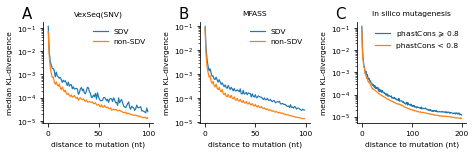

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=get_figure_size(width=0.8, height=0.8/3))
# figure 1&2
size = 200
lw = 1.2

ax = axes[2]
ax.text(-0.1, 1.15, "C", transform=ax.transAxes, fontsize=15, fontweight='normal', va='top', ha='right')
g1 = np.where((cons_all_phastcons >= 0.8))[0]
g2 = np.where((cons_all_phastcons < 0.8))[0]
print(g1.shape, g2.shape)
ax.plot(np.quantile(cons_kl_distance[g1], q=0.5, axis=0)[:size], label=r"phastCons $\geqslant$ 0.8", linewidth=lw)
ax.plot(np.quantile(cons_kl_distance[g2], q=0.5, axis=0)[:size], label='phastCons < 0.8', linewidth=lw)
ax.legend(frameon=False)
ax.set_title("In silico mutagenesis")
set_spines(ax)
ax.set_yscale("log")
ax.set_ylabel("median KL-divergence")
ax.set_xlabel("distance to mutation (nt)")

ax = axes[0]
ax.text(-0.1, 1.15, "A", transform=ax.transAxes, fontsize=15, fontweight='normal', va='top', ha='right')
d = pickle.load(open("./output/vexseq.SpliceBERT.output.pkl", 'rb'))
wt_logits, mt_logits, all_kl, masked_probs, vexseq_prob_change_scores, donor_starts, donor_ends, acceptor_starts, acceptor_ends, vexseq_donor_kl, vexseq_acceptor_kl, flanking_kl, vexseq_kl_distance, vexseq_phastcons_scores, vexseq_phylop_scores, ref_psi, vexseq_delta_psi, vexseq_is_exonic, vexseq_distance, labels, dataset = d.values()
g1 = vexseq_delta_psi < vexseq_cutoff
g2 = ~g1
ax.plot(np.quantile(vexseq_kl_distance[g1], q=0.5, axis=0), label=r"SDV", linewidth=lw)
ax.plot(np.quantile(vexseq_kl_distance[g2], q=0.5, axis=0), label=r"non-SDV", linewidth=lw)
ax.set_ylabel("median KL-divergence")
ax.set_xlabel("distance to mutation (nt)")
ax.set_yscale("log")
ax.set_title("VexSeq(SNV)")
ax.legend(frameon=False)
set_spines(ax)

ax = axes[1]
ax.text(-0.1, 1.15, "B", transform=ax.transAxes, fontsize=15, fontweight='normal', va='top', ha='right')
d = pickle.load(open("./output/mfass.SpliceBERT.output.pkl", 'rb'))
wt_logits, mt_logits, all_kl, masked_probs, mfass_prob_change_scores, donor_starts, donor_ends, acceptor_starts, acceptor_ends, mfass_donor_kl, mfass_acceptor_kl, flanking_kl, mfass_kl_distance, mfass_phastcons_scores, mfass_phylop_scores, ref_psi, mfass_delta_psi, mfass_is_exonic, mfass_distance, mfass_labels, dataset = d.values()
g1 = mfass_delta_psi < -0.5
g2 = ~g1
ax.plot(np.quantile(mfass_kl_distance[g1], q=0.5, axis=0), label=r"SDV", linewidth=lw)
ax.plot(np.quantile(mfass_kl_distance[g2], q=0.5, axis=0), label=r"non-SDV", linewidth=lw)
ax.set_ylabel("median KL-divergence")
ax.set_xlabel("distance to mutation (nt)")
ax.set_yscale("log")
ax.set_title("MFASS")
ax.legend(frameon=False)
set_spines(ax)


plt.tight_layout()
plt.savefig("./Figure_2ABC.svg")
plt.savefig("./Figure_2ABC.jpg", dpi=600)
plt.show()


In [9]:
from biock import scientific_notation

pval 0.05983243389122921
0.5443239472349062 0.49349762130205793 1.1029920383379896
pval 1.5880670700493642e-10
0.6893264840182648 0.4849486476486202 1.4214422235439057
[0.05983243389122921, 1.5880670700493642e-10]
pval 3.93845368663429e-48
0.6380128309269967 0.4902846976426685 1.3013109199504245
pval 9.728707889095826e-62
0.6567983604330327 0.48876467048974803 1.3437926267766305
[3.93845368663429e-48, 9.728707889095826e-62]


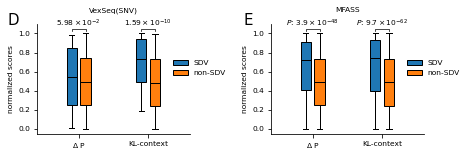

In [15]:
w = 0.15
shift = 0.10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=get_figure_size(0.8, 0.8/3))
ax = axes[0]
ax.text(-0.12, 1.1, "D", transform=ax.transAxes, fontsize=15, fontweight='normal', va='top', ha='right')
inds = np.arange(2)
box_opts = {"medianprops": {"color": "black"}}
# keep = np.arange(len(vexseq_is_exonic)) # np.logical_or(vexseq_is_exonic, abs(vexseq_distance) > 2)
keep = np.logical_or(vexseq_is_exonic.astype(np.bool8), abs(vexseq_distance) > 2)
plot_data_sdv = [
    to_rank(-vexseq_prob_change_scores)[keep][vexseq_delta_psi[keep] < vexseq_cutoff], 
    to_rank(np.log(np.clip(vexseq_kl_distance, a_min=1e-6, a_max=np.inf)).sum(axis=1))[keep][vexseq_delta_psi[keep] < vexseq_cutoff], 
    # to_rank(vexseq_donor_kl + vexseq_acceptor_kl)[keep][vexseq_delta_psi[keep]< vexseq_cutoff]
]
bp1 = ax.boxplot(x=plot_data_sdv, positions=inds - shift, widths=w, patch_artist=True, boxprops=dict(facecolor="tab:blue"), **box_opts)
plot_data_nonsdv = [
    to_rank(-vexseq_prob_change_scores)[keep][vexseq_delta_psi[keep] >= vexseq_cutoff], 
    to_rank(np.log(np.clip(vexseq_kl_distance, a_min=1e-6, a_max=np.inf)).sum(axis=1))[keep][vexseq_delta_psi[keep] >= vexseq_cutoff], 
    # to_rank(vexseq_donor_kl + vexseq_acceptor_kl)[keep][vexseq_delta_psi[keep] >= vexseq_cutoff]
]
bp2 = ax.boxplot(x=plot_data_nonsdv, positions=inds + shift, widths=w, patch_artist=True, boxprops=dict(facecolor="tab:orange"), **box_opts)
for i in range(2):
    x1, x2 = inds[i] - shift, inds[i] + shift
    pval = ttest_ind(plot_data_sdv[i], plot_data_nonsdv[i], alternative="greater").pvalue
    print("pval", pval)
    print(plot_data_sdv[i].mean(), plot_data_nonsdv[i].mean(), plot_data_sdv[i].mean() / plot_data_nonsdv[i].mean())
    mark = scientific_notation(pval, 2)
    y, h, col = 1, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y + h/2, y+h, y+h, y+h/2], lw=.7, c=col)
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', color=col)

ax.set_xticks(inds)
ax.set_xticklabels([r"$\Delta$ P", "KL-context"], rotation=0, ha="center")
ax.set_ylabel("normalized scores")
ax.set_title("VexSeq(SNV)", y=1.05)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['SDV', 'non-SDV'], loc='right', frameon=False, bbox_to_anchor=(1.28, 0.6))
set_spines(ax)
print([ttest_ind(x, y, alternative="greater").pvalue for x, y in zip(plot_data_sdv, plot_data_nonsdv)])

ax = axes[1]
ax.text(-0.12, 1.1, "E", transform=ax.transAxes, fontsize=15, fontweight='normal', va='top', ha='right')
inds = np.arange(2)
box_opts = {"medianprops": {"color": "black"}}
# keep = np.arange(len(mfass_is_exonic)) # np.logical_or(mfass_is_exonic, abs(mfass_distance) > 2)
keep = np.logical_or(mfass_is_exonic.astype(np.bool8), abs(mfass_distance) > 2)
plot_data_sdv = [
    to_rank(-mfass_prob_change_scores)[keep][mfass_delta_psi[keep] < mfass_cutoff], 
    to_rank(np.log(np.clip(mfass_kl_distance, a_min=1e-6, a_max=np.inf)).sum(axis=1))[keep][mfass_delta_psi[keep] < mfass_cutoff], 
    # to_rank(mfass_donor_kl + mfass_acceptor_kl)[keep][mfass_delta_psi[keep] < mfass_cutoff]
]
bp1 = ax.boxplot(x=plot_data_sdv, positions=inds - shift, widths=w, patch_artist=True, boxprops=dict(facecolor="tab:blue"), **box_opts)
plot_data_nonsdv = [
    to_rank(-mfass_prob_change_scores)[keep][mfass_delta_psi[keep] >= mfass_cutoff], 
    to_rank(np.log(np.clip(mfass_kl_distance, a_min=1e-6, a_max=np.inf)).sum(axis=1))[keep][mfass_delta_psi[keep] >= mfass_cutoff], 
    # to_rank(mfass_donor_kl + mfass_acceptor_kl)[keep][mfass_delta_psi[keep] >= mfass_cutoff]
]
bp2 = ax.boxplot(x=plot_data_nonsdv, positions=inds + shift, widths=w, patch_artist=True, boxprops=dict(facecolor="tab:orange"), **box_opts)
# add significance lines
for i in range(2):
    x1, x2 = inds[i] - shift, inds[i] + shift
    pval = ttest_ind(plot_data_sdv[i], plot_data_nonsdv[i], alternative="greater").pvalue
    print("pval", pval)
    print(plot_data_sdv[i].mean(), plot_data_nonsdv[i].mean(), plot_data_sdv[i].mean() / plot_data_nonsdv[i].mean())
    mark = r"$P$: {}".format(scientific_notation(pval, decimal=1))
    y, h, col = 1, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y + h/2, y+h, y+h, y+h/2], lw=.7, c=col)
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', color=col)
ax.set_xticks(inds)
ax.set_xticklabels([r"$\Delta$ P", "KL-context"], rotation=0)
ax.set_ylabel("normalized scores")
ax.set_title("MFASS", y=1.05)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['SDV', 'non-SDV'], loc='right', frameon=False, bbox_to_anchor=(1.28, 0.6))
print([ttest_ind(x, y, alternative="greater").pvalue for x, y in zip(plot_data_sdv, plot_data_nonsdv)])

set_spines(ax)

plt.tight_layout()
# plt.savefig("./Figure_2DE.svg")
# plt.savefig("./Figure_2DE.jpg", dpi=600)
plt.show()


In [14]:
# output = "./output/{}.{}.output.pkl".format(name.lower(), method)
wt_logits, mt_logits, all_kl, masked_probs, prob_change_scores, donor_starts, donor_ends, acceptor_starts, acceptor_ends, donor_kl, acceptor_kl, flanking_kl, kl_distance, phastcons_scores, phylop_scores, ref_psi, delta_psi, is_exonic, distance, labels, dataset  = \
pickle.load(open("./output/vexseq.DNABERT3.output.pkl", 'rb')).values()

./output/vexseq.SpliceBERT.output.pkl
vexseq before [(False, 1873), (True, 98)]
vexseq after [(False, 1866), (True, 83)]
./output/vexseq.SpliceBERT-human.output.pkl
vexseq before [(False, 1873), (True, 98)]
vexseq after [(False, 1866), (True, 83)]
./output/vexseq.DNABERT3.output.pkl
vexseq before [(False, 1873), (True, 98)]
vexseq after [(False, 1866), (True, 83)]
./output/mfass.SpliceBERT.output.pkl
mfass before [(False, 26683), (True, 1050)]
mfass after [(False, 26647), (True, 870)]
./output/mfass.SpliceBERT-human.output.pkl
mfass before [(False, 26683), (True, 1050)]
mfass after [(False, 26647), (True, 870)]
./output/mfass.DNABERT3.output.pkl
mfass before [(False, 26683), (True, 1050)]
mfass after [(False, 26647), (True, 870)]


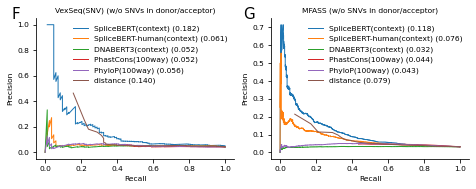

In [9]:
from biock.ml_tools import pr_curve
lw = 1

exclude_splice_site_snvs = True # set to False to include splice site SNVs
if exclude_splice_site_snvs:
    distance_cutoff = 2
else:
    distance_cutoff = None

all_scores = dict()
all_labels = dict()
for name in ["vexseq", "mfass"]:
    if name == "vexseq": 
        cutoff = vexseq_cutoff
    elif name == "mfass":
        cutoff = mfass_cutoff
    all_scores[name] = dict()
    all_labels[name] = dict()
    for method in ["SpliceBERT", "SpliceBERT-human", "DNABERT3"]:
        output = "./output/{}.{}.output.pkl".format(name.lower(), method)
        print(output)
        d = pickle.load(open(output, 'rb'))
        wt_logits, mt_logits, all_kl, masked_probs, prob_change_scores, donor_starts, donor_ends, acceptor_starts, acceptor_ends, donor_kl, acceptor_kl, flanking_kl, kl_distance, phastcons_scores, phylop_scores, ref_psi, delta_psi, is_exonic, distance, labels, dataset = d.values()
        if distance_cutoff is None:
            keep = np.arange(len(labels))
        else:
            print(name, "before", count_items(delta_psi < cutoff))
            keep = np.logical_or(is_exonic.astype(np.int8), abs(distance) >= distance_cutoff)
            print(name, "after", count_items(delta_psi[keep] < cutoff))
        # all_scores[name][method+"(SS)"] = (donor_kl + acceptor_kl)[keep]
        # all_labels[name][method+"(SS)"] = (delta_psi < cutoff)[keep]
        all_scores[name][method+"(context)"] = np.log(np.clip(kl_distance, a_min=1e-6, a_max=np.inf)).sum(axis=1)[keep]
        all_labels[name][method+"(context)"] = (delta_psi < cutoff)[keep]

    all_scores[name]["PhastCons(100way)"] = phastcons_scores[keep]
    all_labels[name]["PhastCons(100way)"] = (delta_psi < cutoff)[keep]
    all_scores[name]["PhyloP(100way)"] = phylop_scores[keep]
    all_labels[name]["PhyloP(100way)"] = (delta_psi < cutoff)[keep]
    all_scores[name]["distance"] = (-distance)[keep]
    all_labels[name]["distance"] = (delta_psi < cutoff)[keep]
    # all_scores[name]["PhyloP+distance"] = (to_rank(-distance) + to_rank(phylop_scores))[keep]
    # all_labels[name]["PhyloP+distance"] = delta_psi[keep] < cutoff
    # for method in all_scores[name]:
    #     print(name, method, average_precision_score(all_labels[name][method], all_scores[name][method]))

# rename = {
#     "splicebert": "SpliceBERT(SS)",
#     "splicebert-human": "SpliceBERT-human(SS)",
#     "splicebert(context)": "SpliceBERT(context)",
#     "splicebert-human(context)": "SpliceBERT-human(context)",
#     "dnabert3": "DNABERT(SS)",
#     "dnabert3(context)": "DNABERT(context)",
# }
rename = {
    # "splicebert": "SpliceBERT(SS)",
    # "splicebert-human": "SpliceBERT-human(SS)",
    "splicebert(context)": "SpliceBERT(KL)",
    "splicebert-human(context)": "SpliceBERT-human(KL)",
    # "dnabert3": "DNABERT(SS)",
    "dnabert3(context)": "DNABERT(KL)",
}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=get_figure_size(0.8, 0.8/2.5))
ax = axes[0]
ax.text(-0.08, 1.08, "F", transform=ax.transAxes, fontsize=15, fontweight='normal', va='top', ha='right')
for method in all_labels["vexseq"]:
    if "(SS)" in rename.get(method, method):
        continue
    p, r, _ = pr_curve(all_labels["vexseq"][method], all_scores["vexseq"][method])
    ax.plot(r, p, linewidth=lw, label="{} ({:.3f})".format(rename.get(method, method), average_precision_score(all_labels["vexseq"][method], all_scores["vexseq"][method])))
ax.legend(frameon=False)
set_spines(ax)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
if distance_cutoff is None:
    ax.set_title("VexSeq(SNV) (all SNVs)")
else:
    ax.set_title("VexSeq(SNV) (w/o SNVs in donor/acceptor)")

ax = axes[1]
ax.text(-0.08, 1.08, "G", transform=ax.transAxes, fontsize=15, fontweight='normal', va='top', ha='right')
for method in all_labels["mfass"]:
    p, r, _ = pr_curve(all_labels["mfass"][method], all_scores["mfass"][method])
    ax.plot(r, p, linewidth=lw, label="{} ({:.3f})".format(rename.get(method, method), average_precision_score(all_labels["mfass"][method], all_scores["mfass"][method])))
ax.legend(frameon=False)
set_spines(ax)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
if distance_cutoff is None:
    ax.set_title("MFASS (all variants)")
else:
    ax.set_title("MFASS (w/o SNVs in donor/acceptor)")

plt.tight_layout()
if distance_cutoff is None:
    plt.savefig("./Figure_S_vexseq_mfass_results.pdf")
    plt.savefig("./Figure_S_vexseq_mfass_results.jpg", dpi=600)
else:
    plt.savefig("./Figure_2_FG.pdf")
    plt.savefig("./Figure_2_FG.jpg", dpi=600)
plt.show()